In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.integrate as integrate
import yaml
import pandas as pd
import sys
from scipy.optimize import minimize_scalar

In [16]:
year = 365.25*3600*24 # 1 year in seconds
GC = 6.67e-11         # Gravitational constant 

In [17]:
# Define class for test case
class Rocky_Planet():
    """ Rocky planet, defines physical parameters and evolution """

    def __init__(self):
        self.parameters()

    def parameters(self):
        pass 

    def A_rho(self):
        return (5. * self.Kprime_0 - 13.) / 10.          # From Labrosse (2015)

    '''Read parameters from yaml file'''
    def read_parameters(self, file):                      
        with open(file, 'r') as stream:
            try:
                dict_param = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        for k, v in dict_param.items():
            setattr(self, k, float(v))

In [18]:
class Evolution():
    ''' Calculates the thermal evolution a given planet '''

    def __init__(self, planet):
        self.planet = planet
        
        '''Initialize all matrices'''
        self.r_IC = np.zeros_like(self.planet.time_vector)
        self.drIC_dt = np.zeros_like(self.planet.time_vector)
        self.T = np.zeros_like(self.planet.time_vector)
        self.dT_dt = np.zeros_like(self.planet.time_vector)
        self.PC = np.zeros_like(self.planet.time_vector)
        self.PL = np.zeros_like(self.planet.time_vector)
        self.PX = np.zeros_like(self.planet.time_vector)
        self.Q_CMB = np.zeros_like(self.planet.time_vector)
        self.T_CMB = np.zeros_like(self.planet.time_vector)
        self.Delta_time = self.planet.time_vector.diff()*year        
        
        '''Initial temperature at the center T0'''
        if self.planet.r_IC_0 == 0.0:
            
            self.T[0] = self.planet.T0                   # If no initial inner core, T0 same as in yaml parameter file
            
        else:
            
            self.T[0] = self.T_melt(self.planet.r_IC_0)  # If initial inner core, define T0 by using the melting temperature
        
        '''Initial inner core radius, powers, CMB heat flux (set to 0 for now), CMB temperature'''
        self.r_IC[0] = self.planet.r_IC_0
        self.PC[0] = self._PC(self.r_IC[0])
        self.PL[0] = self._PL(self.r_IC[0])
        self.PX[0] = self._PX(self.r_IC[0])
        self.Q_CMB[0] = 0.
        self.T_CMB[0] = self.T_adiabat(self.planet.r_OC,self.T[0])
                          
    '''Run evolution model'''         
    def run(self):
        for i,time in enumerate(self.planet.time_vector[1:]):
            
            '''No initial inner core --> update_noic routine'''
            if self.r_IC[i] == 0.0 and self.T[i] > self.planet.TL0:
                              
                T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB =  self.update_noic(self.T[i],self.Delta_time[i+1],self.planet.qcmb[i])
                '''Shift updated value to the next time step'''
                self.T[i+1] = T 
                self.dT_dt[i+1] = dT_dt
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB
                #print (i, T, T_CMB)
                
                '''For the first step at which an inner core starts forming, look for the inner core radius '''
                if self.T[i+1] < self.planet.TL0:

                    self.r_IC[i+1] = self.find_r_IC(T)
                
            else:                 
               
                '''Initial inner core --> update_ic routine'''
                T, r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB =  self.update_ic(self.r_IC[i], self.Delta_time[i+1],self.planet.qcmb[i])
                self.T[i+1] = T
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB
        
        '''Figures'''
        plt.plot(self.planet.time_vector,self.T,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('Temperature at the center (K)')
        plt.gca().set_xlim(left=0)        
        plt.show()
        
        plt.plot(self.planet.time_vector,self.r_IC/1e3,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('Inner core radius (km)')
        plt.gca().set_xlim(left=0) 
        plt.show()
        
        plt.plot(self.planet.time_vector,self.PC, label='Secular cooling')
        plt.plot(self.planet.time_vector,self.PL,label='Latent heat')
        plt.plot(self.planet.time_vector,self.PX, label='Gravitational heat')
        plt.xlabel('Time (years)')
        plt.ylabel('Powers (W)')
        plt.gca().set_xlim(left=0) 
        plt.legend()
        plt.show()
        #print self.Delta_time, self.T[0], self.T[-1]
        #print self.T[-1], self.planet.TL0
        
        plt.plot(self.planet.time_vector,self.Q_CMB,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB heat flow (W)')
        plt.gca().set_xlim(left=0)        
        plt.show()
        
        plt.plot(self.planet.time_vector,self.T_CMB,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB temperature (K)')
        plt.gca().set_xlim(left=0)        
        plt.show()
        
    '''Functions for calculations'''    
    def dTL_dr_IC(self, r):
        ''' Melting temperature jump at ICB (to be modified) '''
        return -self.planet.K_c * 2.*self.planet.dTL_dP * r / self.planet.L_rho**2. \
            + 3. * self.planet.dTL_dchi * self.planet.chi0 * r**2. / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))

    def fC(self, r, delta): 
        '''fC (Eq. A1 Labrosse 2015)'''
        return r**3. * (1 - 3. / 5. * (delta + 1) * r**2.- 3. / 14. * (delta + 1) \
            * (2 * self.planet.A_rho - delta) * r**4.)

    def fX(self, r, r_IC):
        '''fX (Eq. A15 Labrosse 2015)'''
        return (r)**3. * (-r_IC**2. / 3. / self.planet.L_rho**2. + 1./5. * (1.+r_IC**2./self.planet.L_rho**2.) \
                *(r)**2.-13./70. * (r)**4.) 

    def rho(self, r):
        ''' Density (Eq. 5 Labrosse 2015)'''
        return self.planet.rho_c * (1. - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)

    def T_melt(self, r):
        ''' Melting temperature at ICB (Eq. 14 Labrosse 2015)'''
        return self.planet.TL0 - self.planet.K_c * self.planet.dTL_dP * r**2. / self.planet.L_rho**2. + self.planet.dTL_dchi * self.planet.chi0 * r**3. \
                / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))

    def _PL(self, r):
        '''Latent heat power'''
        return 4. * np.pi * r**2. * self.T_melt(r) * self.rho(r) * self.planet.DeltaS


    def _PC(self, r):
        '''Secular cooling power (Eq. A8 Labrosse 2015)'''
        return -4. * np.pi / 3. * self.planet.rho_c * self.planet.CP * self.planet.L_rho**3. *\
                (1 - r**2. / self.planet.L_rho**2 - self.planet.A_rho* r**4. / self.planet.L_rho**4.)**(-self.planet.gamma) \
                * (self.dTL_dr_IC(r) + 2. * self.planet.gamma \
                * self.T_melt(r) * r / self.planet.L_rho**2. *(1 + 2. * self.planet.A_rho * r**2. / self.planet.L_rho**2.) \
                /(1 - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)) \
                * (self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma))


    def _PX(self, r):
        ''' Gravitational heat power (Eq. A14 Labrosse 2015)'''
        return 8 * np.pi**2 * self.planet.chi0 * GC * self.planet.rho_c**2 * self.planet.beta * r**2. \
        * self.planet.L_rho**2. / self.fC(self.planet.r_OC / self.planet.L_rho, 0) \
        * (self.fX(self.planet.r_OC / self.planet.L_rho, r) - self.fX(r / self.planet.L_rho, r))

    def pressure_diff(self,r):  #in GPa
        '''Pressure difference'''
        K0 = self.planet.L_rho**2/3.*2.*np.pi*GC*self.planet.rho_c**2 /1e9 #in GPa
        parenthesis = r**2/self.planet.L_rho**2-4./5.*r**4/self.planet.L_rho**4
        return -K0*parenthesis
    
    def T_adiabat(self,r,T):
        '''Adiabatic temperature'''  # From Labrosse, to be modified!!
        return T*(1-r**2/self.planet.L_rho**2-self.planet.A_rho*r**4/self.planet.L_rho**4)**self.planet.gamma
    
    '''Function for no inner core at the beginning'''
    def update_noic(self,T,Delta_time,qcmb):
        
        fC = self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma)
        
        ''' Secular cooling power '''
        PC = (-4*np.pi/3*self.planet.rho_c*self.planet.CP*self.planet.L_rho**3*fC)
        
        ''' Latent heat power '''
        PL = 0.

        ''' Gravitational heat power '''
        PX = 0.      
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb
        
        '''Temperature increase at center'''
        dT_dt = Q_CMB/PC  
        
        ''' New central temperature '''
        T = T + dT_dt * Delta_time  
        
        ''' Inner core growth '''
        drIC_dt = 0.
        
        ''' Inner core size'''
        r_IC = 0.
        
        '''Temperature at CMB'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        return T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB
    
    '''Function for inner core present at the beginning'''    
    def update_ic(self, r_IC, Delta_time,qcmb):
        
        '''Secular cooling power'''
        PC = self._PC(r_IC)
        
        '''Latent heat power'''
        PL = self._PL(r_IC)
        
        '''Gravitational heat power'''
        PX = self._PX(r_IC)
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb
        
        '''Inner core growth rate'''
        drIC_dt = Q_CMB/(PC + PL + PX)
        
        '''Inner core radius'''
        r_IC = r_IC + drIC_dt * Delta_time
        
        '''Temperature at the center'''
        T = self.T_melt(r_IC)
        
        '''CMB temperature'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        return T,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB
    
    '''Find inner core radius when it first starts forming'''
    def find_r_IC(self, T0):       
        def Delta_T(radius):
            #P = self.pressure_diff(radius, rho_0, Lrho, Arho)+P0
            Ta = self.T_adiabat(radius,T0)
            TL = self.T_melt(radius)
            return (Ta - TL)**2
        res = minimize_scalar(Delta_T, bounds=(0., 6e6), method='bounded') #, constraints={'type':'ineq', 'fun': lambda x: x})  #result has to be >0
        r_IC = res.x
        if r_IC < 1: r_IC = np.array(0.)
        return r_IC.tolist()
        
        

     
#        ## ENERGIES
#        ''' Latent heat '''
#        self.L = 4. * np.pi / 3. * self.planet.rho_c * self.planet.TL0 * self.planet.DeltaS * self.planet.r_IC**3. * (1 - 3. / 5. \
#            * (1 + self.planet.K_c / self.planet.TL0 * self.planet.dTL_dP) * self.planet.r_IC**2. / self.planet.L_rho**2. \
#            + self.planet.chi0 / (2 * self.fC(self.planet.r_OC / self.planet.L_rho, 0.) * self.planet.TL0) * self.planet.dTL_dchi * self.planet.r_IC**3. / self.planet.L_rho**3.)
#        print("Latent heat", self.L,"J")
#        
#        ''' Secular cooling '''
#        self.C = 4. * np.pi / 3. * self.planet.rho_c * self.planet.CP * self.planet.L_rho * self.planet.r_IC**2 * self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma)\
#                * (self.planet.dTL_dP * self.planet.K_c - self.planet.gamma * self.planet.TL0 - self.planet.dTL_dchi * self.planet.chi0 / self.fC(self.planet.r_OC / self.planet.L_rho, 0.) * self.planet.r_IC / self.planet.L_rho)    
#        print("Secular cooling", self.C,"J")
#
#
#        ''' Gravitational energy '''
#        self.G = 8 * np.pi**2. / 15. * self.planet.chi0 * self.planet.GC * self.planet.rho_c**2. * self.planet.beta * self.planet.r_IC**3. * self.planet.r_OC**5. / self.planet.L_rho**3. \
#            / self.fC(self.planet.r_OC/self.planet.L_rho,0)*(1. - self.planet.r_IC**2 / self.planet.r_OC**2 + 3. * self.planet.r_IC**2. / 5. / self.planet.L_rho**2. \
#                - 13. * self.planet.r_OC**2. / 14. / self.planet.L_rho**2. + 5./18. * self.planet.r_IC**3. * self.planet.L_rho**2. /self.planet.r_OC**5.)
#        print("Gravitational energy", self.G,"J")
#
#        ''' Total energy '''
#        self.E_tot = self.L + self.C + self.G
#        print("Total energy", self.E_tot,"J")


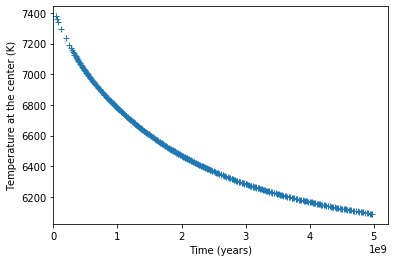

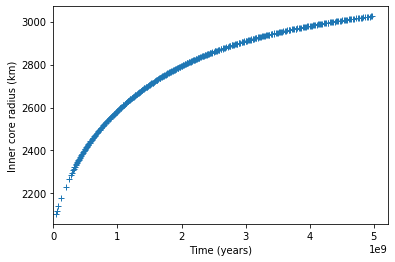

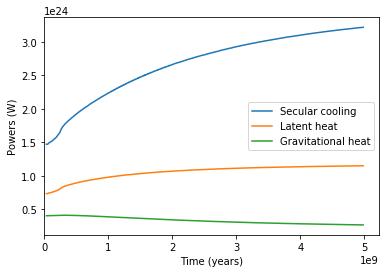

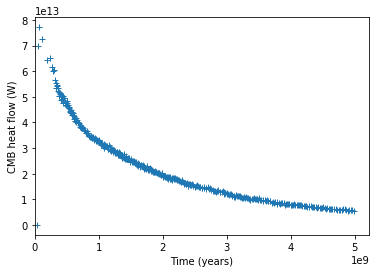

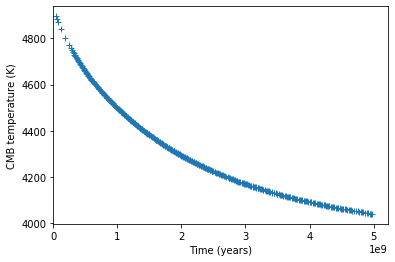

In [21]:
'''Planetary parameters'''
Mp = 1.2
XFe = 50  #50: inner core. 30: no inner core
FeM = 0.00

class Exo(Rocky_Planet):
    
    def parameters(self):
        '''Load all parameter files'''
        self.read_parameters("M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM))
        qcmb_ev = pd.read_csv("qc_T_M{:02d}_Fe{:02d}_FeM{:02d}.txt".format(int(10*Mp),int(XFe)+5, int(FeM)), sep=" ", skiprows=1, header=None)
        qcmb_ev.columns = ["time", "qcmb", "Tcmb"]
        self.time_vector = qcmb_ev["time"]
        self.qcmb = qcmb_ev["qcmb"]

if __name__ == '__main__': 
       
    Evolution(Exo()).run() 